In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [101]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [102]:
data = pd.read_csv('/content/drive/MyDrive/trans.data')
feature_names = ["Recency","Frequency","Monetary","Time","Donated_Blood"]

df = pd.DataFrame(data)

fname = df.columns

df.columns = feature_names
df.head()

,Recency,Frequency,Monetary,Time,Donated_Blood
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Recency        748 non-null    int64
 1   Frequency      748 non-null    int64
 2   Monetary       748 non-null    int64
 3   Time           748 non-null    int64
 4   Donated_Blood  748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


In [104]:
dropped_dups = df.drop_duplicates()
dropped_dups

,Recency,Frequency,Monetary,Time,Donated_Blood
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0
...,...,...,...,...,...
743,23,2,500,38,0
744,21,2,500,52,0
745,23,3,750,62,0
746,39,1,250,39,0


In [105]:
final_df = dropped_dups.dropna()
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 533 entries, 0 to 747
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Recency        533 non-null    int64
 1   Frequency      533 non-null    int64
 2   Monetary       533 non-null    int64
 3   Time           533 non-null    int64
 4   Donated_Blood  533 non-null    int64
dtypes: int64(5)
memory usage: 25.0 KB


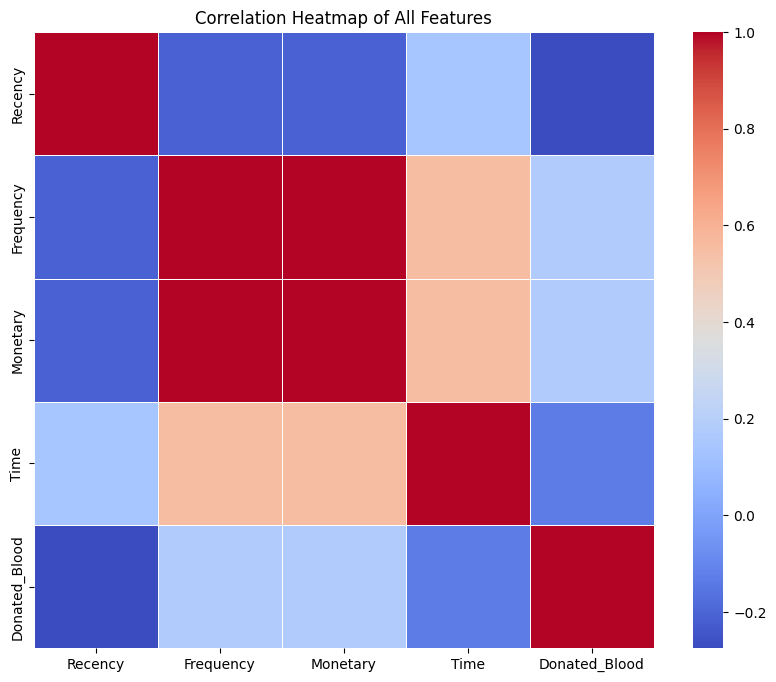

In [106]:
#Correlation Matrix of Features (Without target) then Plotting
corr_mat = final_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of All Features')
plt.show()

In [107]:
last_col = final_df.columns[-1]
X = final_df.drop(last_col, axis=1)
y = final_df[last_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


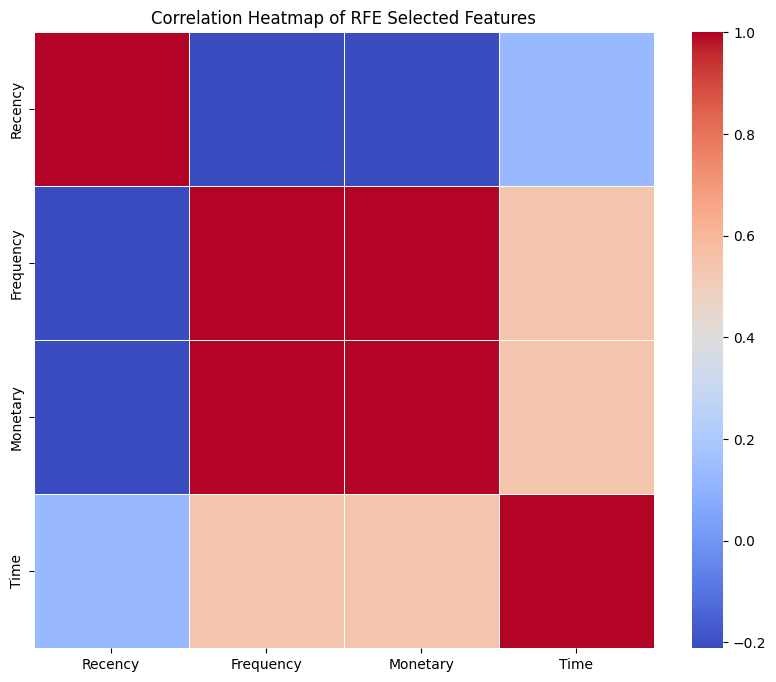

Scores with all features and without any added techniques:
Logistic Regression: 76.64%
Decision Tree: 64.49%
Random Forest: 62.62%
Support Vector Machine: 75.70%

Scores with RFE-selected features:
Logistic Regression: 76.64%
Decision Tree: 64.49%
Random Forest: 62.62%
Support Vector Machine: 75.70%


In [112]:
# Create RFE object and specify the number of features to select
rfe = RFE(estimator=LogisticRegression(max_iter=10000), n_features_to_select=10)

# Fit RFE to training data (excluding the target variable)
rfe.fit(X_train, y_train)

# Transform the training and testing data to include only the selected features
X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

# Convert selected features to DataFrame
df_selected_features = pd.DataFrame(X_train_selected, columns=[feature_names[i] for i, selected in enumerate(rfe.support_) if selected])

# Calculate correlation matrix for selected features
correlation_matrix_selected = df_selected_features.corr()

# Plot correlation heatmap for selected features
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_selected, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of RFE Selected Features')
plt.show()


In [114]:
random_seed = 42

# Define models with random seed
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000, random_state=random_seed),
    "Decision Tree": DecisionTreeClassifier(random_state=random_seed),
    "Random Forest": RandomForestClassifier(random_state=random_seed),
    "Support Vector Machine": SVC(random_state=random_seed)
}


Accuracies without cross validation
Logistic Regression: 0.7664
Decision Tree: 0.6822
Random Forest: 0.6262
Support Vector Machine: 0.7196

Accuracies with cross validation
Logistic Regression: 0.7417
Decision Tree: 0.6033
Random Forest: 0.6690
Support Vector Machine: 0.7347


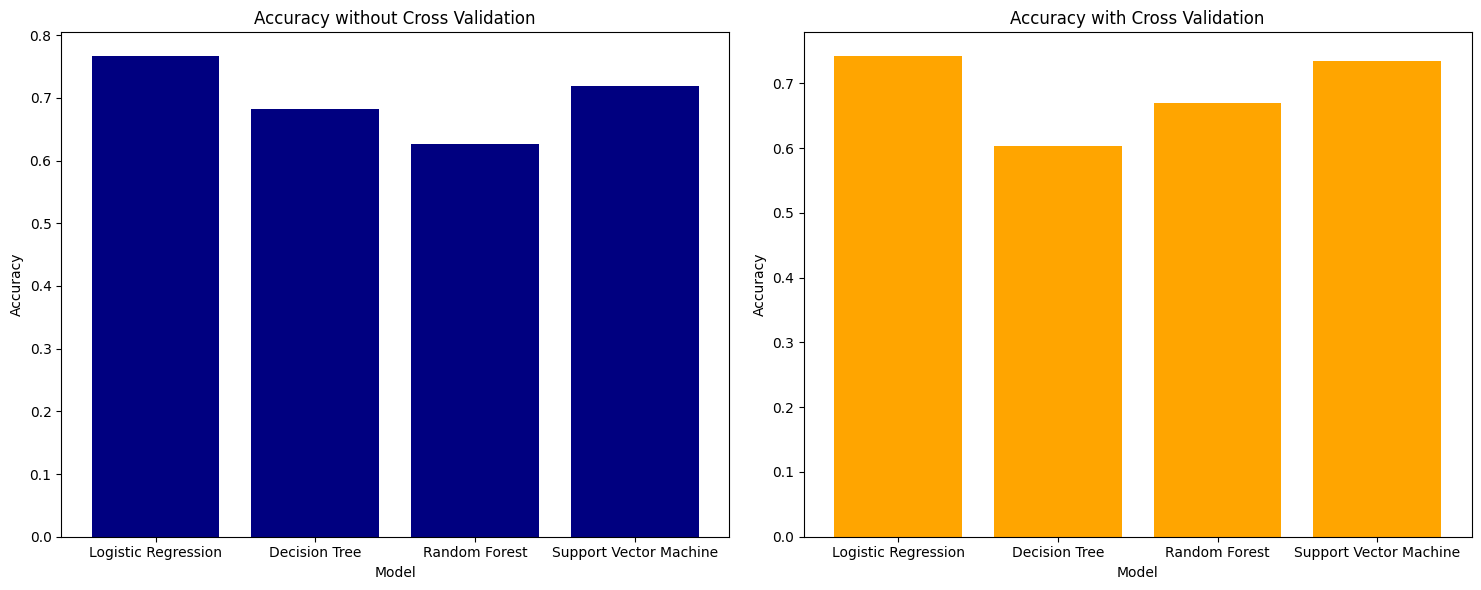

In [110]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Results without cross-validation
accuracies_no_cv = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    accuracies_no_cv[name] = model.score(X_test_scaled, y_test)

print("Accuracies without cross validation")
for name, acc in accuracies_no_cv.items():
    print(f"{name}: {acc:.4f}")

# Results with cross-validation
accuracies_cv = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    accuracies_cv[name] = np.mean(cv_scores)

print("\nAccuracies with cross validation")
for name, acc in accuracies_cv.items():
    print(f"{name}: {acc:.4f}")

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot without cross-validation
ax[0].bar(accuracies_no_cv.keys(), accuracies_no_cv.values(), color='navy')
ax[0].set_title('Accuracy without Cross Validation')
ax[0].set_xlabel('Model')
ax[0].set_ylabel('Accuracy')

# Bar plot with cross-validation
ax[1].bar(accuracies_cv.keys(), accuracies_cv.values(), color='orange')
ax[1].set_title('Accuracy with Cross Validation')
ax[1].set_xlabel('Model')
ax[1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

                    Model  Accuracy      Feature Selection
0     Logistic Regression  0.741724           All Features
1           Decision Tree  0.603283           All Features
2           Random Forest  0.668974           All Features
3  Support Vector Machine  0.734747           All Features
4     Logistic Regression  0.766355  RFE Selected Features
5           Decision Tree  0.644860  RFE Selected Features
6           Random Forest  0.626168  RFE Selected Features
7  Support Vector Machine  0.757009  RFE Selected Features


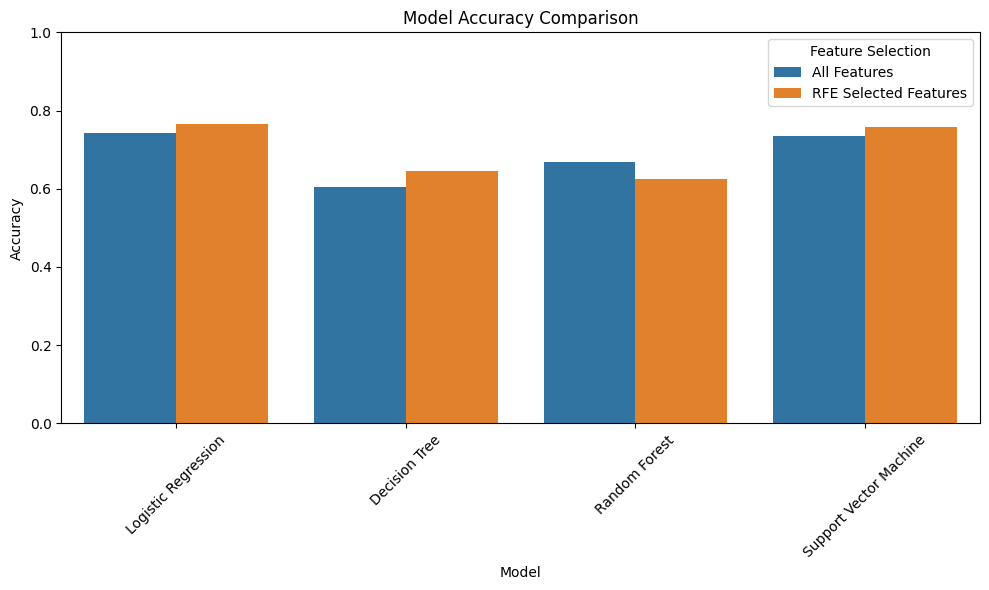

In [111]:
# Train and evaluate models with RFE-selected features
results_rfe_selected_features = {}
for name, model in models.items():
    model.fit(X_train_selected, y_train)
    predictions = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, predictions)
    results_rfe_selected_features[name] = accuracy

# Plotting
results_df = pd.DataFrame({
    "Model": list(accuracies_cv.keys()) + list(results_rfe_selected_features.keys()),
    "Accuracy": list(accuracies_cv.values()) + list(results_rfe_selected_features.values()),
    "Feature Selection": ['All Features'] * len(models) + ['RFE Selected Features'] * len(models)
})

print(results_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Model', y='Accuracy', hue='Feature Selection')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1.0)
plt.legend(title='Feature Selection')
plt.tight_layout()
plt.show()